In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer

import mlflow

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report
)

from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df.sample(5)

,age,weight,height,income_lpa,smoker,city,occupation,insurance_premium_category
79,39,55.3,1.56,30.00,True,Indore,government_job,Low
10,29,71.9,1.77,32.78,True,Chennai,business_owner,Medium
98,27,101.1,1.82,28.30,False,Kolkata,business_owner,Low
20,34,58.2,1.85,30.65,True,Gaya,business_owner,Medium
31,39,51.1,1.83,11.77,True,Lucknow,private_job,Medium


In [4]:
df['occupation'].unique()

array(['retired', 'freelancer', 'student', 'government_job',
       'business_owner', 'unemployed', 'private_job'], dtype=object)

In [5]:
df_feat = df.copy()

In [6]:

(
    df
    .isna()
    .sum()
)

age                           0
weight                        0
height                        0
income_lpa                    0
smoker                        0
city                          0
occupation                    0
insurance_premium_category    0
dtype: int64

#EDA

In [7]:
# distribution of target

(
    df
    .loc[:,'insurance_premium_category']
    .value_counts(normalize=True)
)

insurance_premium_category
Low       0.34
High      0.33
Medium    0.33
Name: proportion, dtype: float64

In [8]:
# boxplots

def create_boxplot(data,column_name,hue=None):
    sns.boxplot(data=data, y=column_name, hue=hue)

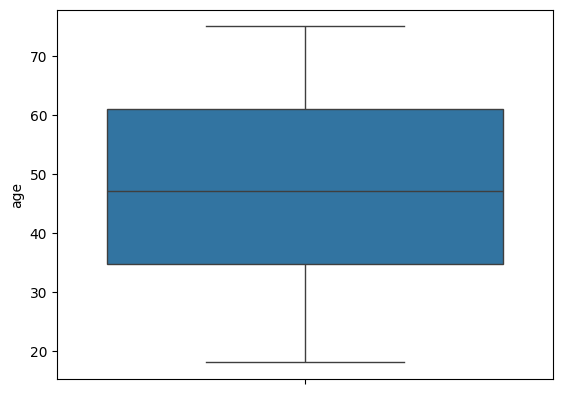

In [300]:
# boxplot for age column
create_boxplot(df,'age')

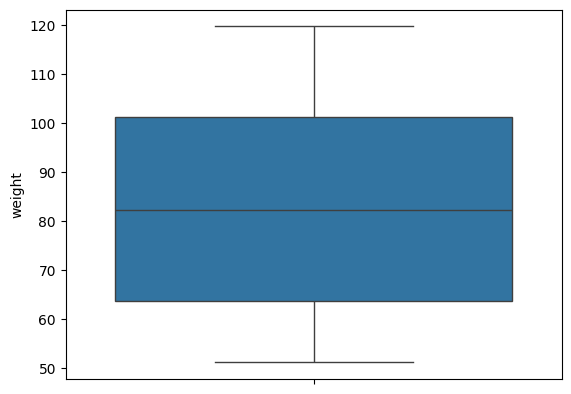

In [9]:
# boxplot for Weight column

create_boxplot(df,'weight')

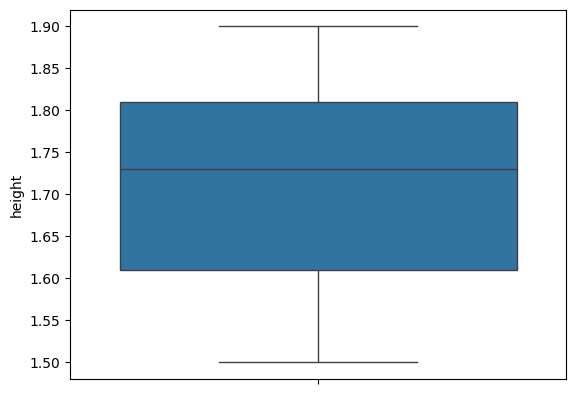

In [10]:
# boxplot for Height column

create_boxplot(df,'height')

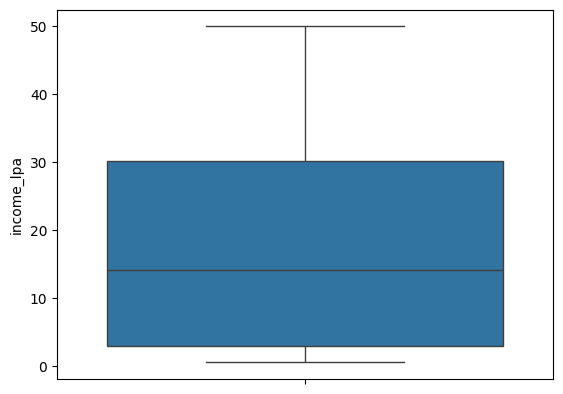

In [11]:
# boxplot for income column

create_boxplot(df,'income_lpa')

In [12]:
# plot the distribution of categorical columns

def plot_distribution(data,column_name):
    sns.countplot(data=data, x=column_name)

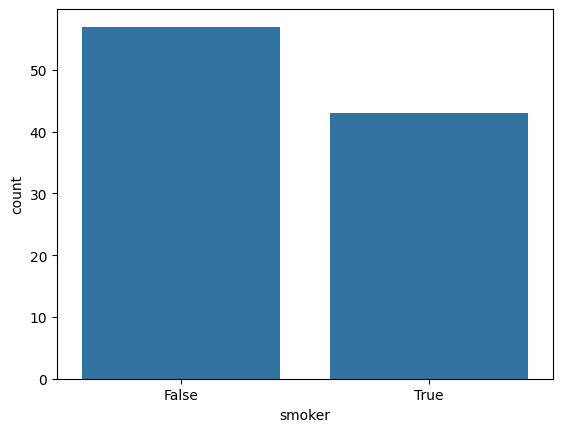

In [14]:
# distribution for smoker
plot_distribution(df,'smoker')

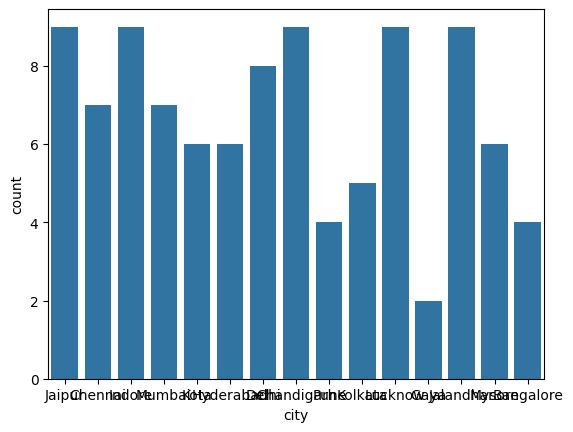

In [15]:
# distribution for city
plot_distribution(df,'city')

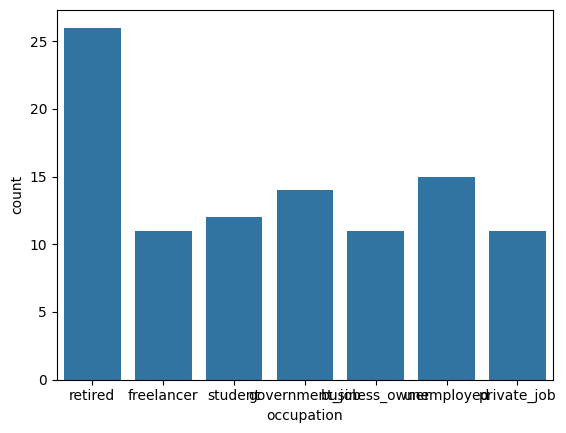

In [16]:
# distribution for occupation 

plot_distribution(df,'occupation')

Feature Engineering

In [17]:
# Feature 1: BMI
df_feat["bmi"] = df_feat["weight"] / (df_feat["height"] ** 2)

In [18]:
# Feature 2: Age Group
def age_group(age):
    if age < 25:
        return "young"
    elif age < 45:
        return "adult"
    elif age < 60:
        return "middle_aged"
    return "senior"

In [19]:
df_feat["age_group"] = df_feat["age"].apply(age_group)

In [21]:
# Feature 3: Lifestyle Risk
def lifestyle_risk(row):
    if row["smoker"] and row["bmi"] > 30:
        return "high"
    elif row["smoker"] or row["bmi"] > 27:
        return "medium"
    else:
        return "low"

In [22]:
df_feat["lifestyle_risk"] = df_feat.apply(lifestyle_risk, axis=1)

In [23]:
tier_1_cities = ["Mumbai", "Delhi", "Bangalore", "Chennai", "Kolkata", "Hyderabad", "Pune"]
tier_2_cities = [
    "Jaipur", "Chandigarh", "Indore", "Lucknow", "Patna", "Ranchi", "Visakhapatnam", "Coimbatore",
    "Bhopal", "Nagpur", "Vadodara", "Surat", "Rajkot", "Jodhpur", "Raipur", "Amritsar", "Varanasi",
    "Agra", "Dehradun", "Mysore", "Jabalpur", "Guwahati", "Thiruvananthapuram", "Ludhiana", "Nashik",
    "Allahabad", "Udaipur", "Aurangabad", "Hubli", "Belgaum", "Salem", "Vijayawada", "Tiruchirappalli",
    "Bhavnagar", "Gwalior", "Dhanbad", "Bareilly", "Aligarh", "Gaya", "Kozhikode", "Warangal",
    "Kolhapur", "Bilaspur", "Jalandhar", "Noida", "Guntur", "Asansol", "Siliguri"
]

In [24]:
# Feature 4: City Tier
def city_tier(city):
    if city in tier_1_cities:
        return 1
    elif city in tier_2_cities:
        return 2
    else:
        return 3

In [25]:
df_feat["city_tier"] = df_feat["city"].apply(city_tier)

In [26]:
df_feat.drop(columns=['age', 'weight', 'height', 'smoker', 'city'])[['income_lpa', 'occupation', 'bmi', 'age_group', 'lifestyle_risk', 'city_tier', 'insurance_premium_category']].sample(5)

,income_lpa,occupation,bmi,age_group,lifestyle_risk,city_tier,insurance_premium_category
67,2.760000,student,17.026929,young,low,2,Low
8,1.780000,retired,23.233456,senior,low,2,Medium
69,6.034487,government_job,21.942857,middle_aged,low,2,Low
13,11.950000,freelancer,27.587429,adult,medium,1,Low
15,2.990000,retired,21.860828,senior,medium,1,Medium


In [27]:
# Select features and target
X = df_feat[["bmi", "age_group", "lifestyle_risk", "city_tier", "income_lpa", "occupation"]]
y = df_feat["insurance_premium_category"]

In [28]:
X

,bmi,age_group,lifestyle_risk,city_tier,income_lpa,occupation
0,49.227482,senior,medium,2,2.92000,retired
1,30.189017,adult,medium,1,34.28000,freelancer
2,21.118382,adult,low,2,36.64000,freelancer
3,45.535900,young,high,1,3.34000,student
4,24.296875,senior,medium,2,3.94000,retired
...,...,...,...,...,...,...
95,21.420747,adult,low,2,19.64000,business_owner
96,47.984483,adult,medium,1,34.01000,private_job
97,18.765432,middle_aged,low,1,44.86000,freelancer
98,30.521676,adult,medium,1,28.30000,business_owner


In [29]:
y

0       High
1        Low
2        Low
3     Medium
4       High
       ...  
95       Low
96       Low
97       Low
98       Low
99       Low
Name: insurance_premium_category, Length: 100, dtype: object

In [30]:
# Define categorical and numeric features
categorical_features = ["age_group", "lifestyle_risk", "occupation", "city_tier"]
numeric_features = ["bmi", "income_lpa"]

In [32]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer


numeric_transformer = Pipeline([  
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())  
])  

categorical_transformer = Pipeline([  
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(sparse_output=False))  
])  


In [33]:
preprocessor = ColumnTransformer(  
    transformers=[  
        ('num', numeric_transformer, numeric_features),  
        ('cat', categorical_transformer, categorical_features)  
    ])  
preprocessor


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e.g. `

In [34]:
# Create a pipeline with preprocessing and random forest classifier
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])
pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [35]:
# Split data and train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)



In [36]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [37]:
# Predict and evaluate
y_pred = pipeline.predict(X_test)

In [38]:
X_test.sample(5)

,bmi,age_group,lifestyle_risk,city_tier,income_lpa,occupation
56,42.414152,young,high,1,2.86,student
51,38.827923,middle_aged,high,2,28.95,private_job
31,15.258742,adult,medium,2,11.77,private_job
32,31.495845,middle_aged,medium,2,50.00,private_job
92,18.319942,adult,medium,2,30.00,government_job


In [39]:
# evaluate the model on the test data
accuracy = accuracy_score(y_test,y_pred)


# 4) Optional: full report for inspection
report = classification_report(y_test, y_pred, digits=4)
print("Classification report:\n", report , accuracy)

Classification report:
               precision    recall  f1-score   support

        High     1.0000    0.7143    0.8333         7
         Low     0.8000    1.0000    0.8889         4
      Medium     0.8000    0.8889    0.8421         9

    accuracy                         0.8500        20
   macro avg     0.8667    0.8677    0.8548        20
weighted avg     0.8700    0.8500    0.8484        20
 0.85


In [40]:
# metrics dict

metrics = {
    'acc': accuracy
}

metrics

{'acc': 0.85}

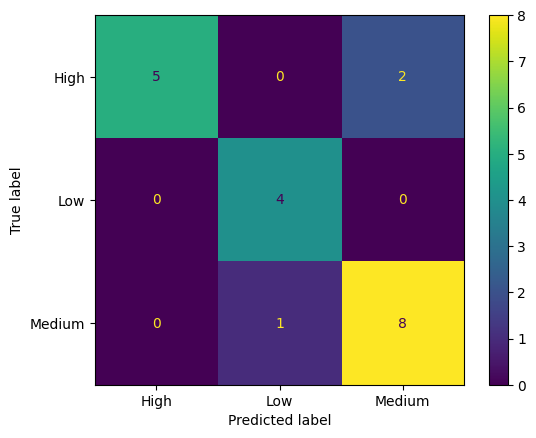

In [41]:
# plot confusion matrix

cm = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [42]:
# MLFlow Tracking code

In [43]:
pipeline.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('scaler', StandardScaler())]),
                                    ['bmi', 'income_lpa']),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(sparse_output=False))]),
                                    ['age_group', 'lifestyle_risk', 'occupation',
                                     'city_tier'])])),
  ('classifier', RandomForestClassifier(random_state=42))],
 'transform_input': None,
 'verbose': False,
 'preprocessor': 

In [44]:
X_test.join(y_test)

,bmi,age_group,lifestyle_risk,city_tier,income_lpa,occupation,insurance_premium_category
80,34.350461,middle_aged,medium,2,50.000000,unemployed,High
84,28.801497,senior,medium,2,0.620000,retired,High
33,21.791064,senior,low,1,1.460000,retired,Medium
81,31.866055,adult,high,2,22.190000,freelancer,High
93,23.199416,young,low,2,1.280000,student,Low
17,31.176471,senior,medium,1,2.230000,retired,Medium
36,21.713266,senior,low,1,0.530000,retired,Medium
82,17.874812,adult,low,1,12.960000,unemployed,Low
69,21.942857,middle_aged,low,2,6.034487,government_job,Low
65,37.662982,middle_aged,high,2,38.070000,unemployed,High


In [46]:
# set the uri for server

mlflow.set_tracking_uri("http://127.0.0.1:8000")

mlflow.set_experiment("MSAI Project : Predict Premium Category")

with mlflow.start_run() as run:
    # log the data signature
    data_signature = mlflow.models.infer_signature(model_input=X_train,model_output=pipeline.predict(X_train))

    # log preprocessor parameters
    mlflow.log_params(pipeline.get_params())

    # log model metrics
    mlflow.log_metrics(metrics)
    
    # log the model
    mlflow.sklearn.log_model(sk_model=pipeline,artifact_path="msai_model",signature=data_signature)

    # Get the model uri
    model_uri = mlflow.get_artifact_uri("model.pkl")
    
    # # evaluate the model
    # evaluations = mlflow.models.evaluate(model=model_uri,
    #                        data=X_test.join(y_test),
    #                        targets='survived',
    #                        model_type="classifier")

    # log the confusion matrix
    mlflow.log_figure(cm.figure_,artifact_file='confusion_matrix.png')


/opt/anaconda3/envs/msai_env2/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2026/01/07 06:28:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run resilient-wren-172 at: http://127.0.0.1:8000/#/experiments/1/runs/d5f1f0be910f401586141bf9e85d2366
🧪 View experiment at: http://127.0.0.1:8000/#/experiments/1


In [337]:
import pickle

# Save the trained pipeline using pickle
pickle_model_path = "model.pkl"
with open(pickle_model_path, "wb") as f:
    pickle.dump(pipeline, f)
